## Net Cycle Flux Testing
#### Date: 5/24/2023

$\textbf{Objective:}$ The goal is to figure out why the net cycle flux for cycle 1 (EmrE) has a net cycle flux of zero across all values of $R_{\text{off}}$.

In [1]:
import numpy as np
import pandas as pd
import sympy
import networkx as nx
import matplotlib.pyplot as plt

from kda import calculations, diagrams, graph_utils 

In [2]:
def get_K(
    k31=1, k13=1, k57=1, k75=1, k42=1, k24=1, 
    k68=1, k86=1, k34=1, k43=1, k56=1, k65=1, 
    k12=1, k21=1, k78=1, k87=1, k71=1, k17=1, 
    k53=1, k35=1, k64=1, k46=1, k82=1, k28=1,
):
    K = np.array(
        [
            [0, k12, k13, 0, 0, 0, k17, 0],
            [k21, 0, 0, k24, 0, 0, 0, k28],
            [k31, 0, 0, k34, k35, 0, 0, 0],
            [0, k42, k43, 0, 0, k46, 0, 0],
            [0, 0, k53, 0, 0, k56, k57, 0],
            [0, 0, 0, k64, k65, 0, 0, k68],
            [k71, 0, 0, 0, k75, 0, 0, k78],
            [0, k82, 0, 0, 0, k86, k87, 0],
        ]
    )
    return K

def get_K_vals(k_EH_H, k_ED_D, k_EHD_H, k_EHD_D, k_AA):
    """
    k_EH_H : [1, 1e6] --- k13, k75
    k_ED_D : [1e-2, 1e4] --- k43, k65
    k_EHD_H : [1, 1e6] --- k24, k86
    k_EHD_D : [1e-2, 1e4] --- k21, k87

    k_ED_D / k_EHD_D = k_EH_H / k_EHD_H
    """
    H_on = 1e10
    D_on = 1e7
    H_in = 10 ** (-6.5)
    H_out = 10 ** (-7.5)
    c_D = 25e-9

    K = get_K(
        k31=H_on * H_out,
        k13=k_EH_H,
        k57=H_on * H_in,
        k75=k_EH_H,
        k42=H_on * H_out,
        k24=k_EHD_H,
        k68=H_on * H_in,
        k86=k_EHD_H,
        k34=D_on * c_D,
        k43=k_ED_D,
        k56=D_on * c_D,
        k65=k_ED_D,
        k12=D_on * c_D,
        k21=k_EHD_D,
        k78=D_on * c_D,
        k87=k_EHD_D,
        k71=k_AA,
        k17=k_AA,
        k53=k_AA,
        k35=k_AA,
        k64=k_AA,
        k46=k_AA,
        k82=k_AA,
        k28=k_AA,
    )
    return K

def get_sigma_data(k_EH_H, k_ED_D, k_EHD_H, k_EHD_D, k_AA, dir_edges):

    sigma_data = np.zeros((len(k_AA), len(k_EH_H)))
    for i, kAA in enumerate(k_AA): 
        for j, (EH_H, ED_D, EHD_H, EHD_D) in enumerate(zip(k_EH_H, k_ED_D, k_EHD_H, k_EHD_D)):
            K_tmp = get_K_vals(k_EH_H=EH_H, k_ED_D=ED_D, k_EHD_H=EHD_H, k_EHD_D=EHD_D, k_AA=kAA)
            G_tmp = nx.MultiDiGraph()
            graph_utils.generate_edges(G_tmp, K_tmp)

            sigma_data[i, j] = calculations.calc_sigma(
                G=G_tmp,
                dirpar_edges=dir_edges, 
                key="val", 
                output_strings=False,
            )
    return sigma_data

def get_net_cycle_flux_data(k_EH_H, k_ED_D, k_EHD_H, k_EHD_D, k_AA, cycles):
    n_datasets = len(k_EH_H)
    n_cycles = len(cycles)
    n_kAA_vals = len(k_AA)
    pi_data = np.zeros((n_cycles, n_kAA_vals, n_datasets))
    sigma_K_data = np.zeros((n_cycles, n_kAA_vals, n_datasets))

    for idx, cycle_info in cycles.items():
        for j, kAA in enumerate(k_AA):
            for k, (EH_H, ED_D, EHD_H, EHD_D) in enumerate(zip(k_EH_H, k_ED_D, k_EHD_H, k_EHD_D)):
                i = idx-1
                K_tmp = get_K_vals(k_EH_H=EH_H, k_ED_D=ED_D, k_EHD_H=EHD_H, k_EHD_D=EHD_D, k_AA=kAA)
                G_tmp = nx.MultiDiGraph()
                graph_utils.generate_edges(G_tmp, K_tmp)

                pi_data[i, j, k] = calculations.calc_pi_difference(
                    G=G_tmp, 
                    cycle=cycle_info["cycle"], 
                    order=cycle_info["order"], 
                    key="val", 
                    output_strings=False,
                )
                flux_diags = diagrams.generate_flux_diagrams(G=G_tmp, cycle=cycle_info["cycle"])
                sigma_K_data[i, j, k] = calculations.calc_sigma_K(
                    G=G_tmp, 
                    cycle=cycle_info["cycle"], 
                    flux_diags=flux_diags, 
                    key="val", 
                    output_strings=False,
                )
    return (pi_data, sigma_K_data)

def plot_cycle_data(x, y_arr, cycle_idx, logy=False, max_logx=1):
    fig = plt.figure(figsize=(8, 5), tight_layout=True)
    ax = fig.add_subplot(111)

    def get_ls_lw(i):
        if i % 2 == 0:
            return ("-", 1)
        else:
            return ("--", 2)

    if logy:
        plotting_func = ax.loglog
    else:
        plotting_func = ax.semilogx

    for i, idx in enumerate(cycle_idx):
        ls, lw = get_ls_lw(i)
        plotting_func(
            x,
            y_arr[idx],
            ls=ls,
            lw=lw,
            label=f"Cycle {idx+1}",
        )

    ax.set_xlim(10 ** -max_logx, 10 ** max_logx)
    ax.axvline(x=1, ymin=0, ymax=1, ls="--", label=r"$R_{\mathrm{AA}}=1$", color="black")
    ax.set_xlabel(r"$R_{\mathrm{AA}}$")
    plt.legend(bbox_to_anchor=(1, 1), loc="upper left", ncol=1)
    ax.grid(True)

Generate the diagram with arbitrary rates (i.e. 1):

In [3]:
K = get_K()
G = nx.MultiDiGraph()
graph_utils.generate_edges(G, K)

In [4]:
# define the cycles manually (for repeatability)
EmrE_cycles = {
	1: {"cycle": [0, 1, 3, 2, 4, 5, 7, 6], "order": [6, 0]}, 
	2: {"cycle": [0, 6, 7, 5, 4, 2], "order": [6, 0]}, 
	3: {"cycle": [0, 6, 7, 5, 3, 2], "order": [6, 0]}, 
	4: {"cycle": [0, 6, 7, 5, 3, 1], "order": [6, 0]},
    5: {"cycle": [0, 2, 4, 5, 3, 1, 7, 6], "order": [6, 0]},
	6: {"cycle": [0, 6, 7, 1, 3, 2], "order": [6, 0]}, 
	7: {"cycle": [0, 6, 7, 1], "order": [6, 0]}, 
	8: {"cycle": [0, 2, 3, 1, 7, 5, 4, 6], "order": [6, 0]}, 
	9: {"cycle": [0, 6, 4, 5, 7, 1], "order": [6, 0]}, 
	10: {"cycle": [0, 6, 4, 5, 3, 2], "order": [6, 0]}, 
	11: {"cycle": [0, 6, 4, 5, 3, 1], "order": [6, 0]}, 
    12: {"cycle": [0, 1, 7, 5, 3, 2, 4, 6], "order": [6, 0]},
	13: {"cycle": [0, 6, 4, 2, 3, 1], "order": [6, 0]}, 
	14: {"cycle": [0, 6, 4, 2], "order": [6, 0]}, 
	15: {"cycle": [0, 1, 3, 5, 7, 6, 4, 2], "order": [0, 2]}, 
	16: {"cycle": [0, 2, 4, 6, 7, 1], "order": [0, 2]}, 
	17: {"cycle": [0, 2, 4, 5, 7, 1], "order": [0, 2]}, 
	18: {"cycle": [0, 2, 4, 5, 3, 1], "order": [0, 2]}, 
	19: {"cycle": [0, 2, 3, 5, 7, 1], "order": [0, 2]}, 
	20: {"cycle": [0, 1, 7, 6, 4, 5, 3, 2], "order": [0, 2]},
    21: {"cycle": [0, 1, 3, 2], "order": [0, 2]},
	22: {"cycle": [1, 7, 6, 4, 5, 3], "order": [1, 3]}, 
	23: {"cycle": [1, 7, 6, 4, 2, 3], "order": [2, 4]}, 
	24: {"cycle": [1, 7, 5, 4, 2, 3], "order": [2, 4]}, 
	25: {"cycle": [1, 7, 5, 3], "order": [1, 3]}, 
	26: {"cycle": [2, 3, 5, 7, 6, 4], "order": [2, 4]}, 
	27: {"cycle": [2, 3, 5, 4], "order": [2, 4]},
    28: {"cycle": [6, 7, 5, 4], "order": [7, 5]},
	}

Create the $k_\text{AA}$ data:

In [5]:
n_datasets = 201

# favor antiport initially by using large EHD values first
k_EH_H = np.logspace(-2, 8, n_datasets)
k_EHD_H = np.logspace(-2, 8, n_datasets)[::-1]
k_ED_D = np.logspace(-4, 6, n_datasets)
k_EHD_D = np.logspace(-4, 6, n_datasets)[::-1]
k_AA = np.array([1, 10, 100, 1000])

R_off_H = k_EH_H / k_EHD_H
R_off_D = k_ED_D / k_EHD_D
# double check that we are getting identical arrays here
np.testing.assert_allclose(R_off_H, R_off_D)

In [6]:
# collect the directional edges from the generic G beforehand
# since the edges do not change when the rates are changed below
dir_edges = diagrams.generate_directional_diagrams(G, return_edges=True)

In [7]:
sigma_data = get_sigma_data(k_EH_H, k_ED_D, k_EHD_H, k_EHD_D, k_AA, dir_edges=dir_edges)

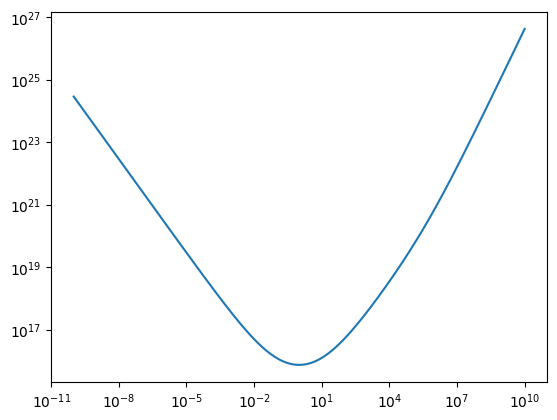

In [8]:
plt.loglog(R_off_H, sigma_data[0])

Now that we know $\Sigma$ is so incredibly large, lets take a look at the $\Pi_+$ and $\Pi_-$ values for cycles that go through all 8 states since they all have a $\Sigma_\text{K}$ of 1.

My $\textit{hypothesis}$ is the net cycle fluxes for these cycles will all be very close to zero $\textit{because}$ their $\Sigma_\text{K}$ values are 1. Cycle with flux diagrams likely have much higher net cycle flux numerators since many of the rates are very large, basically. 

In [9]:
pi_data, sigma_K_data = get_net_cycle_flux_data(k_EH_H, k_ED_D, k_EHD_H, k_EHD_D, k_AA, cycles=EmrE_cycles)
num_data = pi_data * sigma_K_data
J_K_data = num_data/sigma_data

Cycle [0, 1, 3, 2, 4, 5, 7, 6] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 1, 3, 2, 4, 5, 7, 6]. Sigma K value is 1.
Cycle [0, 1, 3, 2, 4, 5, 7, 6] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 1, 3, 2, 4, 5, 7, 6]. Sigma K value is 1.
Cycle [0, 1, 3, 2, 4, 5, 7, 6] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 1, 3, 2, 4, 5, 7, 6]. Sigma K value is 1.
Cycle [0, 1, 3, 2, 4, 5, 7, 6] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 1, 3, 2, 4, 5, 7, 6]. Sigma K value is 1.
Cycle [0, 1, 3, 2, 4, 5, 7, 6] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 1, 3, 2, 4, 5, 7, 6]. Sigma K value is 1.
Cycle [0, 1, 3, 2, 4, 5, 7, 6] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 1, 3, 2, 4, 5, 7, 6]. Sigma K value is 1.
Cycl

Cycle [0, 6, 7, 5, 4, 2, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 5, 4, 2, 3, 1]. Sigma K value is 1.
Cycle [0, 6, 7, 5, 4, 2, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 5, 4, 2, 3, 1]. Sigma K value is 1.
Cycle [0, 6, 7, 5, 4, 2, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 5, 4, 2, 3, 1]. Sigma K value is 1.
Cycle [0, 6, 7, 5, 4, 2, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 5, 4, 2, 3, 1]. Sigma K value is 1.
Cycle [0, 6, 7, 5, 4, 2, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 5, 4, 2, 3, 1]. Sigma K value is 1.
Cycle [0, 6, 7, 5, 4, 2, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 5, 4, 2, 3, 1]. Sigma K value is 1.
Cycl

Cycle [0, 6, 7, 5, 4, 2, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 5, 4, 2, 3, 1]. Sigma K value is 1.
Cycle [0, 6, 7, 5, 4, 2, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 5, 4, 2, 3, 1]. Sigma K value is 1.
Cycle [0, 6, 7, 5, 4, 2, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 5, 4, 2, 3, 1]. Sigma K value is 1.
Cycle [0, 6, 7, 5, 4, 2, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 5, 4, 2, 3, 1]. Sigma K value is 1.
Cycle [0, 6, 7, 5, 4, 2, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 5, 4, 2, 3, 1]. Sigma K value is 1.
Cycle [0, 6, 7, 5, 4, 2, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 5, 4, 2, 3, 1]. Sigma K value is 1.
Cycl

Cycle [0, 6, 7, 5, 4, 2, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 5, 4, 2, 3, 1]. Sigma K value is 1.
Cycle [0, 6, 7, 5, 4, 2, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 5, 4, 2, 3, 1]. Sigma K value is 1.
Cycle [0, 6, 7, 5, 4, 2, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 5, 4, 2, 3, 1]. Sigma K value is 1.
Cycle [0, 6, 7, 5, 4, 2, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 5, 4, 2, 3, 1]. Sigma K value is 1.
Cycle [0, 6, 7, 5, 4, 2, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 5, 4, 2, 3, 1]. Sigma K value is 1.
Cycle [0, 6, 7, 5, 4, 2, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 5, 4, 2, 3, 1]. Sigma K value is 1.
Cycl

Cycle [0, 6, 7, 5, 4, 2, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 5, 4, 2, 3, 1]. Sigma K value is 1.
Cycle [0, 6, 7, 5, 4, 2, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 5, 4, 2, 3, 1]. Sigma K value is 1.
Cycle [0, 6, 7, 5, 4, 2, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 5, 4, 2, 3, 1]. Sigma K value is 1.
Cycle [0, 6, 7, 5, 4, 2, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 5, 4, 2, 3, 1]. Sigma K value is 1.
Cycle [0, 6, 7, 5, 4, 2, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 5, 4, 2, 3, 1]. Sigma K value is 1.
Cycle [0, 6, 7, 5, 4, 2, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 5, 4, 2, 3, 1]. Sigma K value is 1.
Cycl

Cycle [0, 6, 7, 5, 4, 2, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 5, 4, 2, 3, 1]. Sigma K value is 1.
Cycle [0, 6, 7, 5, 4, 2, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 5, 4, 2, 3, 1]. Sigma K value is 1.
Cycle [0, 6, 7, 5, 4, 2, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 5, 4, 2, 3, 1]. Sigma K value is 1.
Cycle [0, 6, 7, 5, 4, 2, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 5, 4, 2, 3, 1]. Sigma K value is 1.
Cycle [0, 6, 7, 5, 4, 2, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 5, 4, 2, 3, 1]. Sigma K value is 1.
Cycle [0, 6, 7, 5, 4, 2, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 5, 4, 2, 3, 1]. Sigma K value is 1.
Cycl

Cycle [0, 6, 7, 5, 4, 2, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 5, 4, 2, 3, 1]. Sigma K value is 1.
Cycle [0, 6, 7, 5, 4, 2, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 5, 4, 2, 3, 1]. Sigma K value is 1.
Cycle [0, 6, 7, 5, 4, 2, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 5, 4, 2, 3, 1]. Sigma K value is 1.
Cycle [0, 6, 7, 5, 4, 2, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 5, 4, 2, 3, 1]. Sigma K value is 1.
Cycle [0, 6, 7, 5, 4, 2, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 5, 4, 2, 3, 1]. Sigma K value is 1.
Cycle [0, 6, 7, 1, 3, 5, 4, 2] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 1, 3, 5, 4, 2]. Sigma K value is 1.
Cycl

Cycle [0, 6, 7, 1, 3, 5, 4, 2] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 1, 3, 5, 4, 2]. Sigma K value is 1.
Cycle [0, 6, 7, 1, 3, 5, 4, 2] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 1, 3, 5, 4, 2]. Sigma K value is 1.
Cycle [0, 6, 7, 1, 3, 5, 4, 2] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 1, 3, 5, 4, 2]. Sigma K value is 1.
Cycle [0, 6, 7, 1, 3, 5, 4, 2] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 1, 3, 5, 4, 2]. Sigma K value is 1.
Cycle [0, 6, 7, 1, 3, 5, 4, 2] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 1, 3, 5, 4, 2]. Sigma K value is 1.
Cycle [0, 6, 7, 1, 3, 5, 4, 2] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 1, 3, 5, 4, 2]. Sigma K value is 1.
Cycl

Cycle [0, 6, 7, 1, 3, 5, 4, 2] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 1, 3, 5, 4, 2]. Sigma K value is 1.
Cycle [0, 6, 7, 1, 3, 5, 4, 2] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 1, 3, 5, 4, 2]. Sigma K value is 1.
Cycle [0, 6, 7, 1, 3, 5, 4, 2] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 1, 3, 5, 4, 2]. Sigma K value is 1.
Cycle [0, 6, 7, 1, 3, 5, 4, 2] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 1, 3, 5, 4, 2]. Sigma K value is 1.
Cycle [0, 6, 7, 1, 3, 5, 4, 2] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 1, 3, 5, 4, 2]. Sigma K value is 1.
Cycle [0, 6, 7, 1, 3, 5, 4, 2] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 1, 3, 5, 4, 2]. Sigma K value is 1.
Cycl

Cycle [0, 6, 4, 5, 7, 1, 3, 2] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 5, 7, 1, 3, 2]. Sigma K value is 1.
Cycle [0, 6, 4, 5, 7, 1, 3, 2] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 5, 7, 1, 3, 2]. Sigma K value is 1.
Cycle [0, 6, 4, 5, 7, 1, 3, 2] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 5, 7, 1, 3, 2]. Sigma K value is 1.
Cycle [0, 6, 4, 5, 7, 1, 3, 2] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 5, 7, 1, 3, 2]. Sigma K value is 1.
Cycle [0, 6, 4, 5, 7, 1, 3, 2] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 5, 7, 1, 3, 2]. Sigma K value is 1.
Cycle [0, 6, 4, 5, 7, 1, 3, 2] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 5, 7, 1, 3, 2]. Sigma K value is 1.
Cycl

Cycle [0, 6, 4, 5, 7, 1, 3, 2] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 5, 7, 1, 3, 2]. Sigma K value is 1.
Cycle [0, 6, 4, 5, 7, 1, 3, 2] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 5, 7, 1, 3, 2]. Sigma K value is 1.
Cycle [0, 6, 4, 5, 7, 1, 3, 2] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 5, 7, 1, 3, 2]. Sigma K value is 1.
Cycle [0, 6, 4, 5, 7, 1, 3, 2] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 5, 7, 1, 3, 2]. Sigma K value is 1.
Cycle [0, 6, 4, 5, 7, 1, 3, 2] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 5, 7, 1, 3, 2]. Sigma K value is 1.
Cycle [0, 6, 4, 5, 7, 1, 3, 2] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 5, 7, 1, 3, 2]. Sigma K value is 1.
Cycl

Cycle [0, 6, 4, 5, 7, 1, 3, 2] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 5, 7, 1, 3, 2]. Sigma K value is 1.
Cycle [0, 6, 4, 5, 7, 1, 3, 2] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 5, 7, 1, 3, 2]. Sigma K value is 1.
Cycle [0, 6, 4, 5, 7, 1, 3, 2] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 5, 7, 1, 3, 2]. Sigma K value is 1.
Cycle [0, 6, 4, 5, 7, 1, 3, 2] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 5, 7, 1, 3, 2]. Sigma K value is 1.
Cycle [0, 6, 4, 5, 7, 1, 3, 2] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 5, 7, 1, 3, 2]. Sigma K value is 1.
Cycle [0, 6, 4, 5, 7, 1, 3, 2] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 5, 7, 1, 3, 2]. Sigma K value is 1.
Cycl

Cycle [0, 6, 4, 2, 3, 5, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 2, 3, 5, 7, 1]. Sigma K value is 1.
Cycle [0, 6, 4, 2, 3, 5, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 2, 3, 5, 7, 1]. Sigma K value is 1.
Cycle [0, 6, 4, 2, 3, 5, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 2, 3, 5, 7, 1]. Sigma K value is 1.
Cycle [0, 6, 4, 2, 3, 5, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 2, 3, 5, 7, 1]. Sigma K value is 1.
Cycle [0, 6, 4, 2, 3, 5, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 2, 3, 5, 7, 1]. Sigma K value is 1.
Cycle [0, 6, 4, 2, 3, 5, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 2, 3, 5, 7, 1]. Sigma K value is 1.
Cycl

Cycle [0, 6, 4, 2, 3, 5, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 2, 3, 5, 7, 1]. Sigma K value is 1.
Cycle [0, 6, 4, 2, 3, 5, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 2, 3, 5, 7, 1]. Sigma K value is 1.
Cycle [0, 6, 4, 2, 3, 5, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 2, 3, 5, 7, 1]. Sigma K value is 1.
Cycle [0, 6, 4, 2, 3, 5, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 2, 3, 5, 7, 1]. Sigma K value is 1.
Cycle [0, 6, 4, 2, 3, 5, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 2, 3, 5, 7, 1]. Sigma K value is 1.
Cycle [0, 6, 4, 2, 3, 5, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 2, 3, 5, 7, 1]. Sigma K value is 1.
Cycl

Cycle [0, 6, 4, 2, 3, 5, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 2, 3, 5, 7, 1]. Sigma K value is 1.
Cycle [0, 6, 4, 2, 3, 5, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 2, 3, 5, 7, 1]. Sigma K value is 1.
Cycle [0, 6, 4, 2, 3, 5, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 2, 3, 5, 7, 1]. Sigma K value is 1.
Cycle [0, 6, 4, 2, 3, 5, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 2, 3, 5, 7, 1]. Sigma K value is 1.
Cycle [0, 6, 4, 2, 3, 5, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 2, 3, 5, 7, 1]. Sigma K value is 1.
Cycle [0, 6, 4, 2, 3, 5, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 2, 3, 5, 7, 1]. Sigma K value is 1.
Cycl

Cycle [0, 2, 4, 6, 7, 5, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 4, 6, 7, 5, 3, 1]. Sigma K value is 1.
Cycle [0, 2, 4, 6, 7, 5, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 4, 6, 7, 5, 3, 1]. Sigma K value is 1.
Cycle [0, 2, 4, 6, 7, 5, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 4, 6, 7, 5, 3, 1]. Sigma K value is 1.
Cycle [0, 2, 4, 6, 7, 5, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 4, 6, 7, 5, 3, 1]. Sigma K value is 1.
Cycle [0, 2, 4, 6, 7, 5, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 4, 6, 7, 5, 3, 1]. Sigma K value is 1.
Cycle [0, 2, 4, 6, 7, 5, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 4, 6, 7, 5, 3, 1]. Sigma K value is 1.
Cycl

Cycle [0, 2, 4, 6, 7, 5, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 4, 6, 7, 5, 3, 1]. Sigma K value is 1.
Cycle [0, 2, 4, 6, 7, 5, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 4, 6, 7, 5, 3, 1]. Sigma K value is 1.
Cycle [0, 2, 4, 6, 7, 5, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 4, 6, 7, 5, 3, 1]. Sigma K value is 1.
Cycle [0, 2, 4, 6, 7, 5, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 4, 6, 7, 5, 3, 1]. Sigma K value is 1.
Cycle [0, 2, 4, 6, 7, 5, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 4, 6, 7, 5, 3, 1]. Sigma K value is 1.
Cycle [0, 2, 4, 6, 7, 5, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 4, 6, 7, 5, 3, 1]. Sigma K value is 1.
Cycl

Cycle [0, 2, 4, 6, 7, 5, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 4, 6, 7, 5, 3, 1]. Sigma K value is 1.
Cycle [0, 2, 4, 6, 7, 5, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 4, 6, 7, 5, 3, 1]. Sigma K value is 1.
Cycle [0, 2, 4, 6, 7, 5, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 4, 6, 7, 5, 3, 1]. Sigma K value is 1.
Cycle [0, 2, 4, 6, 7, 5, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 4, 6, 7, 5, 3, 1]. Sigma K value is 1.
Cycle [0, 2, 4, 6, 7, 5, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 4, 6, 7, 5, 3, 1]. Sigma K value is 1.
Cycle [0, 2, 4, 6, 7, 5, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 4, 6, 7, 5, 3, 1]. Sigma K value is 1.
Cycl

Cycle [0, 2, 4, 6, 7, 5, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 4, 6, 7, 5, 3, 1]. Sigma K value is 1.
Cycle [0, 2, 4, 6, 7, 5, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 4, 6, 7, 5, 3, 1]. Sigma K value is 1.
Cycle [0, 2, 4, 6, 7, 5, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 4, 6, 7, 5, 3, 1]. Sigma K value is 1.
Cycle [0, 2, 4, 6, 7, 5, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 4, 6, 7, 5, 3, 1]. Sigma K value is 1.
Cycle [0, 2, 4, 6, 7, 5, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 4, 6, 7, 5, 3, 1]. Sigma K value is 1.
Cycle [0, 2, 4, 6, 7, 5, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 4, 6, 7, 5, 3, 1]. Sigma K value is 1.
Cycl

Cycle [0, 2, 4, 6, 7, 5, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 4, 6, 7, 5, 3, 1]. Sigma K value is 1.
Cycle [0, 2, 4, 6, 7, 5, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 4, 6, 7, 5, 3, 1]. Sigma K value is 1.
Cycle [0, 2, 4, 6, 7, 5, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 4, 6, 7, 5, 3, 1]. Sigma K value is 1.
Cycle [0, 2, 4, 6, 7, 5, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 4, 6, 7, 5, 3, 1]. Sigma K value is 1.
Cycle [0, 2, 4, 6, 7, 5, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 4, 6, 7, 5, 3, 1]. Sigma K value is 1.
Cycle [0, 2, 4, 6, 7, 5, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 4, 6, 7, 5, 3, 1]. Sigma K value is 1.
Cycl

Cycle [0, 2, 4, 6, 7, 5, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 4, 6, 7, 5, 3, 1]. Sigma K value is 1.
Cycle [0, 2, 4, 6, 7, 5, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 4, 6, 7, 5, 3, 1]. Sigma K value is 1.
Cycle [0, 2, 4, 6, 7, 5, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 4, 6, 7, 5, 3, 1]. Sigma K value is 1.
Cycle [0, 2, 4, 6, 7, 5, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 4, 6, 7, 5, 3, 1]. Sigma K value is 1.
Cycle [0, 2, 4, 6, 7, 5, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 4, 6, 7, 5, 3, 1]. Sigma K value is 1.
Cycle [0, 2, 4, 6, 7, 5, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 4, 6, 7, 5, 3, 1]. Sigma K value is 1.
Cycl

Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycl

Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycl

Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycl

Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycl

Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycl

Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycl

Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycl

Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycl

Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycl

Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycl

Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycl

Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycl

Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycl

The primary contributors to the operational flux near $R_\text{off} = 1$ are cycles 14 and 25.

In [10]:
print(J_K_data.shape)
# kAA = [1, 10, 100, 1000]
# we want the k_AA=100 case
k_AA_idx = 2

# cycle index definitions
all_cycle_idx = [i for i in range(len(EmrE_cycles))]
zero_flux_cycle_idx = [4, 5, 6, 7, 8, 11, 14, 17, 20, 25, 26, 27]
nonzero_flux_cycle_idx = [i for i in all_cycle_idx if not i in zero_flux_cycle_idx]
anti_cycle_idx = [2, 3, 9, 10]
sym_cycle_idx = [15, 16, 22, 23]

(28, 4, 201)


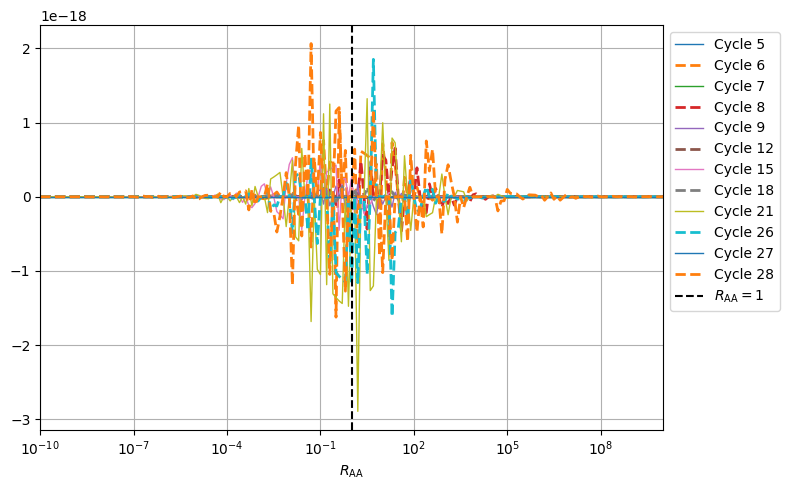

In [11]:
# zero net cycle flux cycles
plot_cycle_data(x=R_off_H, y_arr=J_K_data[:, k_AA_idx, :], cycle_idx=zero_flux_cycle_idx, logy=False, max_logx=10)

The following are all of the non-zero cycles. Only the symport and antiport cycles produce non-zero drug fluxes, so they are only relevant for the proton fluxes.

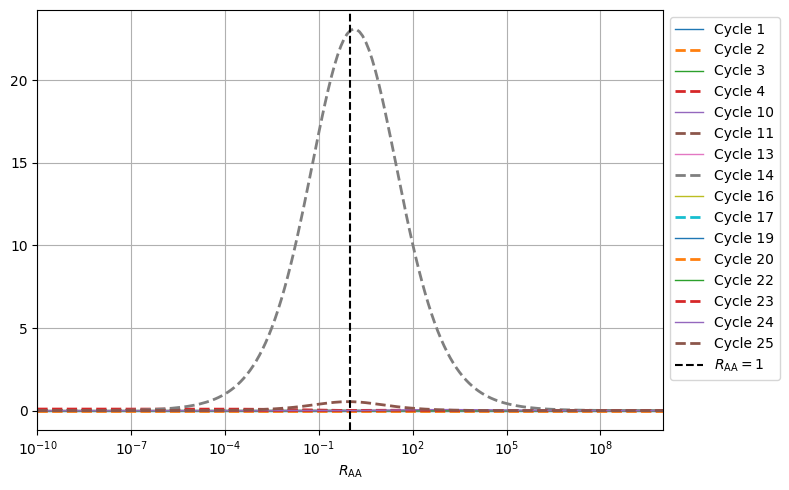

In [12]:
# non-zero cycles
plot_cycle_data(x=R_off_H, y_arr=J_K_data[:, k_AA_idx, :], cycle_idx=nonzero_flux_cycle_idx, logy=False, max_logx=10)

Here are the antiport cycles. They die off pretty quickly once $R_{\text{off}}$ increases past 1.

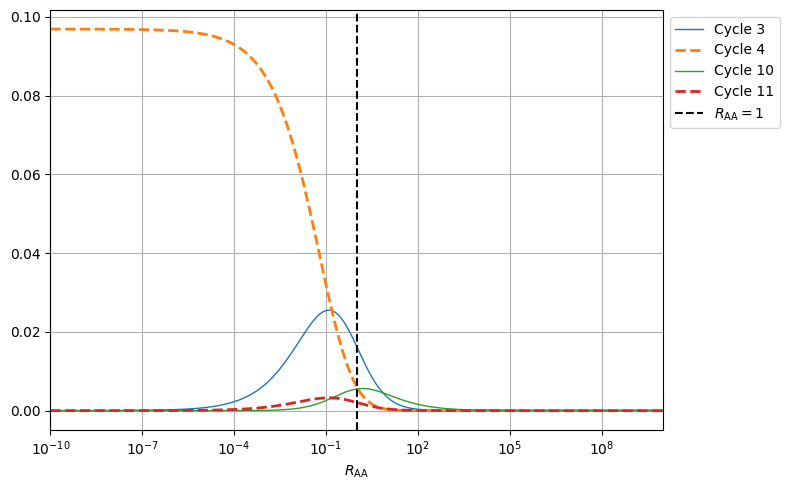

In [13]:
# antiport cycles
plot_cycle_data(x=R_off_H, y_arr=J_K_data[:, k_AA_idx, :], cycle_idx=anti_cycle_idx, logy=False, max_logx=10)

Here are the symport cycles. The only cycle here that contributes at the extreme is cycle 24

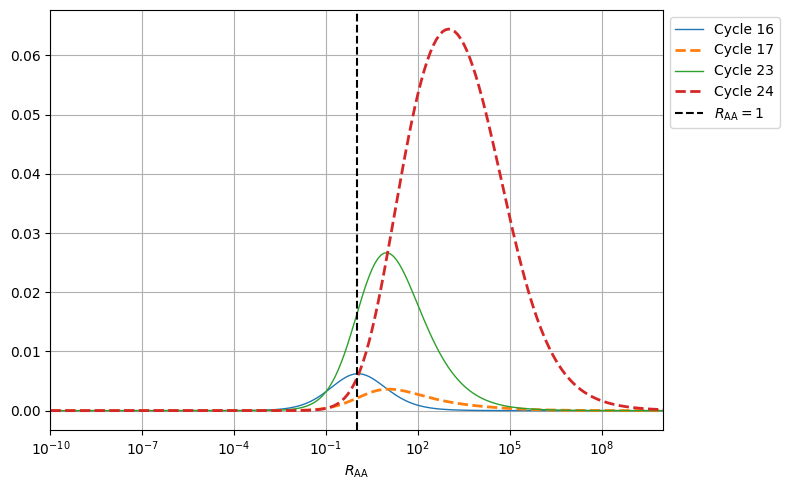

In [14]:
# symport cycles
plot_cycle_data(x=R_off_H, y_arr=J_K_data[:, k_AA_idx, :], cycle_idx=sym_cycle_idx, logy=False, max_logx=10)

### $\Pi_{+} - \Pi_{-}$ Analysis

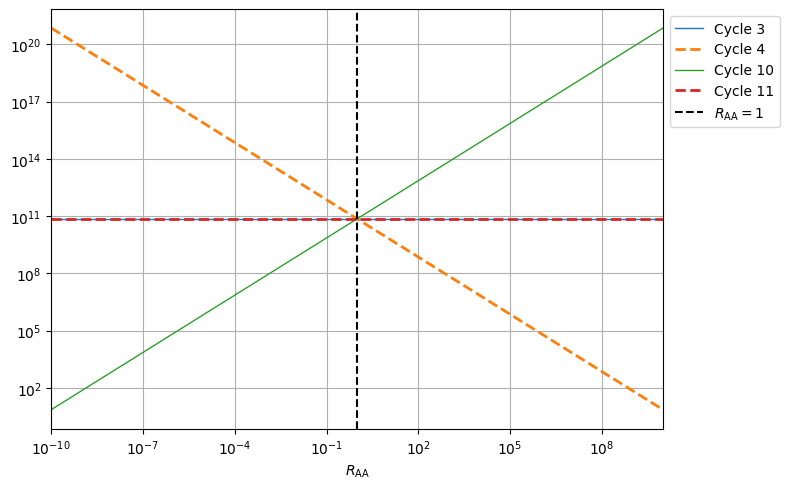

In [15]:
# antiport
plot_cycle_data(x=R_off_H, y_arr=pi_data[:, k_AA_idx, :], cycle_idx=anti_cycle_idx, logy=True, max_logx=10)

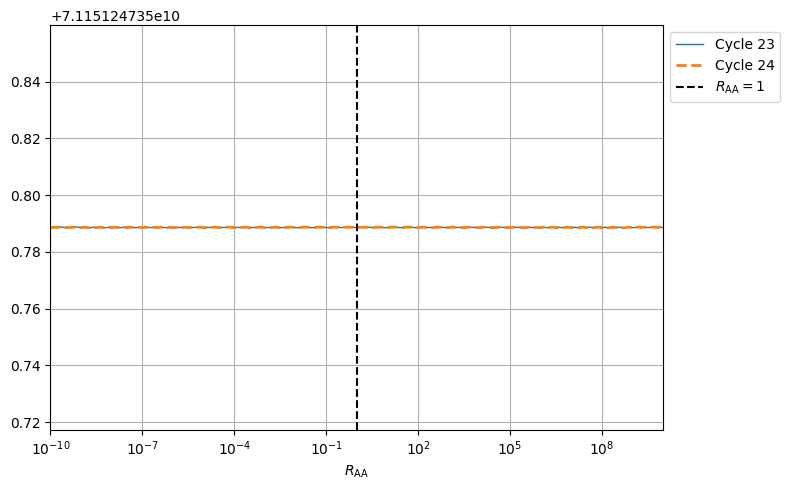

In [16]:
#symport
plot_cycle_data(x=R_off_H, y_arr=pi_data[:, k_AA_idx, :], cycle_idx=sym_cycle_idx[2:], logy=False, max_logx=10)

### $\Sigma_K$ Analysis

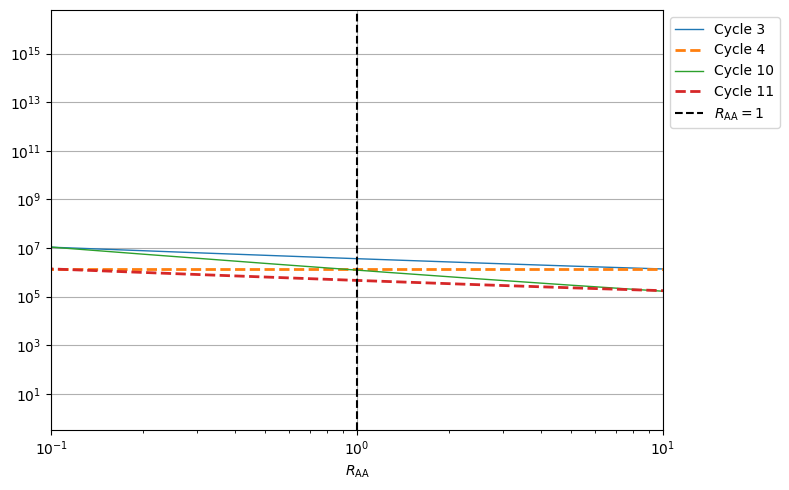

In [17]:
# antiport
plot_cycle_data(x=R_off_H, y_arr=sigma_K_data[:, k_AA_idx, :], cycle_idx=anti_cycle_idx, logy=True, max_logx=1)

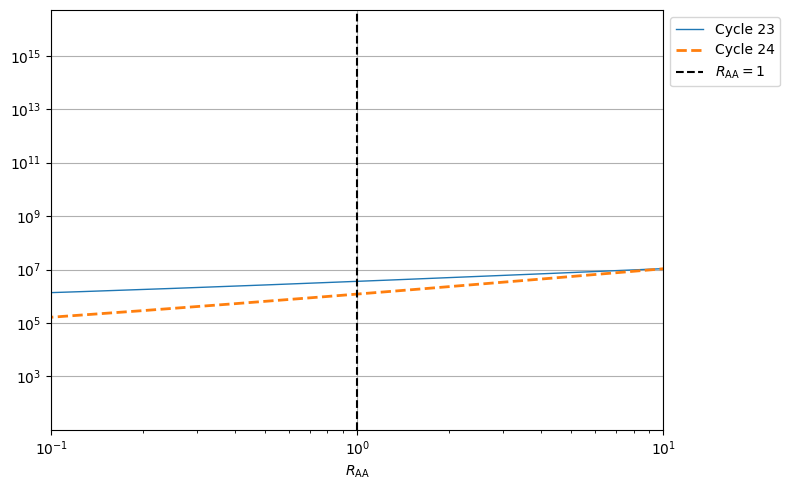

In [18]:
# symport
plot_cycle_data(x=R_off_H, y_arr=sigma_K_data[:, k_AA_idx, :], cycle_idx=sym_cycle_idx[2:], logy=True, max_logx=1)

### $\Sigma$ Analysis

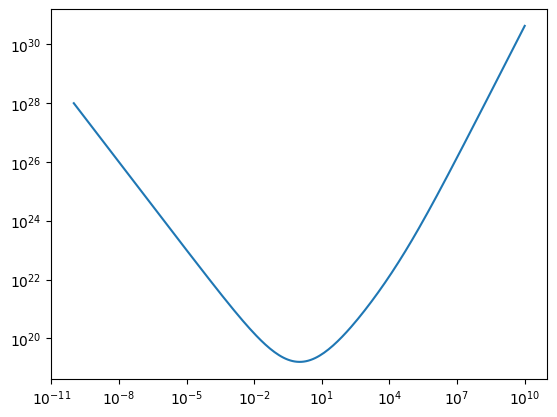

In [19]:
plt.loglog(R_off_H, sigma_data[k_AA_idx])

### Store Net Cycle Fluxes

In [20]:
def fmtscientific(x):
    """
    Formats a multiple of 10 in scientific notation (i.e. "$1 \times 10^3$").
    """
    if x == 0.0 or x < 1e-16:
        # if value is zero or below machine epsilon simply return the decimal
        return f"{np.abs(x):.0f}"
    # start with python scientific notation
    sci_str = f"{x:.1e}"
    # split the string into base and power
    base, pwr = sci_str.split("e")
    # cast as integer to remove the `+` signs and leading zeros
    pwr = str(int(pwr))
    # set in math text
    formatted_str = r"$" + base + r"\times 10^{" + pwr + r"}$"
    return formatted_str

In [48]:
_k_EH_H = np.array([1e-2, 1e3, 1e4, 1e8])
_k_EHD_H = np.array([1e8, 1e3, 1e2, 1e-2])
_k_ED_D = np.array([1e-4, 1e1, 1e2, 1e6])
_k_EHD_D = np.array([1e6, 1e1, 1e0, 1e-4])
_k_AA = np.array([100])

In [57]:
_sigma_data = get_sigma_data(_k_EH_H, _k_ED_D, _k_EHD_H, _k_EHD_D, _k_AA, dir_edges=dir_edges)
_pi_data, _sigma_K_data = get_net_cycle_flux_data(_k_EH_H, _k_ED_D, _k_EHD_H, _k_EHD_D, _k_AA, cycles=EmrE_cycles)

data = (_pi_data * _sigma_K_data) / _sigma_data
# collapse array down to 28x4
data = data[:, 0, :]

Cycle [0, 1, 3, 2, 4, 5, 7, 6] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 1, 3, 2, 4, 5, 7, 6]. Sigma K value is 1.
Cycle [0, 1, 3, 2, 4, 5, 7, 6] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 1, 3, 2, 4, 5, 7, 6]. Sigma K value is 1.
Cycle [0, 1, 3, 2, 4, 5, 7, 6] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 1, 3, 2, 4, 5, 7, 6]. Sigma K value is 1.
Cycle [0, 1, 3, 2, 4, 5, 7, 6] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 1, 3, 2, 4, 5, 7, 6]. Sigma K value is 1.
Cycle [0, 2, 4, 5, 3, 1, 7, 6] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 4, 5, 3, 1, 7, 6]. Sigma K value is 1.
Cycle [0, 2, 4, 5, 3, 1, 7, 6] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 4, 5, 3, 1, 7, 6]. Sigma K value is 1.
Cycl

In [60]:
columns = [r"$\mathrm{R}_\mathrm{off}=10^{-10}$", r"$\mathrm{R}_\mathrm{off}=10^{0}$", r"$\mathrm{R}_\mathrm{off}=10^{2}$", r"$\mathrm{R}_\mathrm{off}=10^{10}$"]
index = [cycle_idx for cycle_idx in EmrE_cycles]
df = pd.DataFrame(data=data, index=index, columns=columns)
df.index.name = "Cycle"
df.to_csv("Roff_net_cycle_flux_table.csv")

In [62]:
df = df.map(fmtscientific)

In [65]:
# df.to_latex()